In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline

In [2]:
def NGD(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
# NGD orignal model with constant time memory
def NGD_const(x,alpha,tau_NGD,K):
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for k in range(len(T)-1):
        if T[k]>tau_NGD:
            F=y[k-int(tau_NGD/dt)]
        else:
            F=0
        dy=dt*(-alpha*y[k]+K*(x[k]-F))
        y[k+1]=y[k]+dy
    return y,z

In [4]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [6]:
def FFT_quick(data):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(x), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

(-4.989000000000001, 104.989)

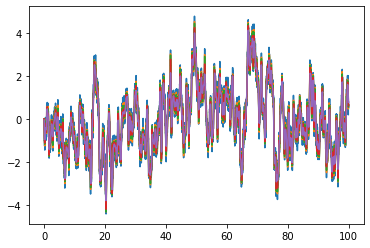

In [7]:
# generate OU
Tot=100
dt=0.01
T=np.arange(dt,Tot,dt)
tau=1
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering
fc=[10,7,4,2]
x_set=[L]
for ifc in range(len(fc)):
    b, a = signal.butter(2, 2*fc[ifc]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    x_set.append(Lf)
    
for i in range(np.size(x_set,0)):
    plt.plot(T,x_set[i])
plt.xlim()

In [8]:
y_set=[[] for i in range(len(x_set))]
z_set=[[] for i in range(len(x_set))]
alpha,beta,K,g=6,1.6,22,10
for i in range(len(x_set)):
    y_set[i],z_set[i]=NGD(x_set[i],alpha,beta,K,g,1)
#     y_set[i],z_set[i]=NGD(x_set[i],8,1.4,37,10,1)

In [9]:
MI_set=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    timeshift,MI_set[i]=MI(EqualState(x_set[i],8),EqualState(y_set[i],8),dt,[-1,1])

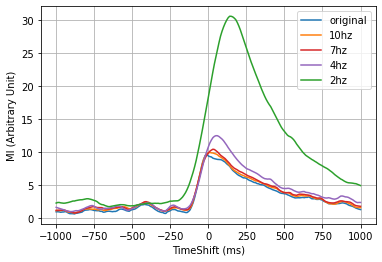

In [10]:
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(timeshift*1000,MI_set[i],color=colorlist[i]) 
    legend_list=[str(fc[j])+'hz' for j in range(len(fc))]
    legend_list.insert(0,'original')
#     plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.legend((legend_list))
    plt.xlabel('TimeShift (ms)')
    plt.ylabel('MI (Arbitrary Unit)')
plt.grid()
plt.show()
#     plt.xlim(-500,500)

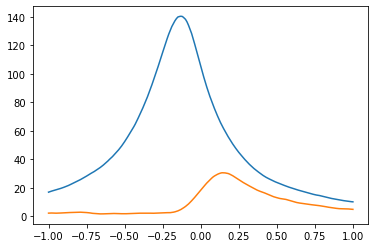

In [11]:
# without feedback
y0,z0=NGD(x_set[-1],alpha,beta,K,g,0)
timeshift,MI0=MI(EqualState(x_set[0],8),EqualState(y0,8),dt,[-1,1])
plt.plot(timeshift,MI0)
plt.plot(timeshift,MI_set[-1])

In [12]:
# find cross correlation as simulated STA
corr_set=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    corr_same=np.correlate(x_set[i],y_set[i],'same')
    corr_set[i]=corr_same[int(len(corr_same+1)/2)-int(1/dt):int(len(corr_same+1)/2)+int(1/dt)]
    corr_set[i]=corr_set[i]/max(abs(corr_set[i]))
timelag=np.arange(-int(1/dt),int(1/dt))*dt 

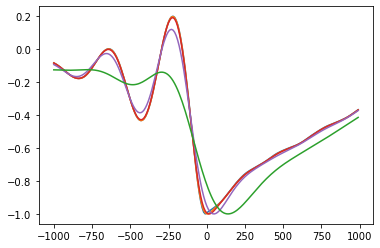

In [13]:
colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
for i in range(len(corr_set)):
    plt.plot(timelag*1000,-corr_set[i],color=colorlist[i])

0.06


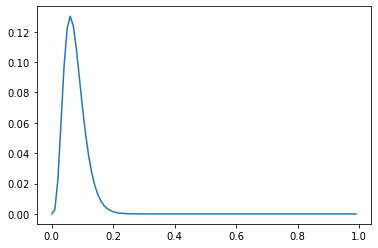

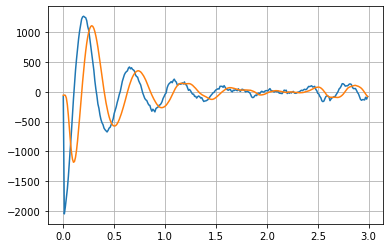

In [14]:
# calculate the equivalent temporal kernel
# dt=0.001
T=np.arange(0,int(Tot/dt))*dt
mu, sigma = 0, 1 # mean and standard deviation
x_ori = np.random.normal(mu, sigma, len(T))
timek=1
t_k=np.arange(0,int(1/dt))*dt
tau_x=0.015
kx=t_k**4*np.exp(-t_k/tau_x)/tau_x**2
kx=kx/np.sum(kx)
plt.plot(t_k,kx)
print(t_k[np.argmax(kx)])
plt.show()

x_delay=np.convolve(x_ori,kx,'valid')
alpha1,beta1,K1,g1=6,1.2,20,10
y_ori,z_ori=NGD(x_ori,alpha1,beta1,K1,g1,1)
y_convolved,z_convolved=NGD(x_delay,alpha1,beta1,K1,g1,1)

corr1=np.correlate(x_ori,y_ori,'same')
corr2=np.correlate(x_ori[len(kx)-1:],y_convolved,'same')

corr_window=int(3/dt)
plt.plot(np.arange(0,corr_window)*dt,-corr1[round((len(corr1))/2):round((len(corr1))/2-corr_window):-1])
plt.plot(np.arange(0,corr_window)*dt,-corr2[round((len(corr2))/2):round((len(corr2))/2-corr_window):-1])
plt.xlim()
plt.grid()
plt.show()


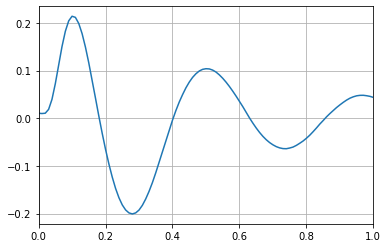

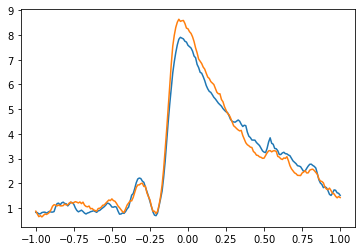

In [15]:
# use the equivalent temporal kernel to generate the output
t_tempk=np.arange(0,int(5/dt))*dt
equi_temp_k=corr2[round((len(corr2))/2):round((len(corr2))/2-len(t_tempk)):-1]
equi_temp_k=equi_temp_k/np.sqrt(sum(equi_temp_k**2))
# equi_temp_k=np.zeros(300)
# equi_temp_k[0]=1
plt.plot(t_tempk,equi_temp_k)
plt.xlim(0,1)
plt.grid()
plt.show()

x_selected=x_set[0]
y_equi_temp_k=np.convolve(x_selected,equi_temp_k,'valid')
TS_temp_k,MI_temp_k=MI(EqualState(x_selected[len(equi_temp_k)-1:],8),EqualState(y_equi_temp_k,8),dt,[-1,1])
plt.plot(TS_temp_k,MI_temp_k)6

x_delay_NGD=np.convolve(x_selected,kx,'valid')
y_NGD,z_NGD=NGD(x_delay_NGD,alpha1,beta1,K1,g1,1)
TS_NGD,MI_NGD=MI(EqualState(x_selected[len(kx)-1:],8),EqualState(y_NGD,8),dt,[-1,1])
plt.plot(TS_NGD,MI_NGD)

(40000.0, 45000.0)

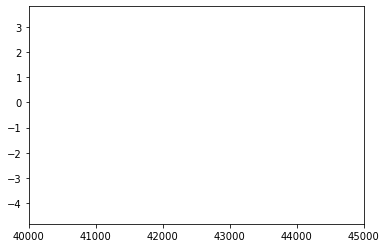

In [16]:
plt.plot(y_equi_temp_k/np.std(y_equi_temp_k))
plt.plot(y_NGD/np.std(y_NGD))
plt.xlim(40000,45000)

(-1.0995, 1.0895)

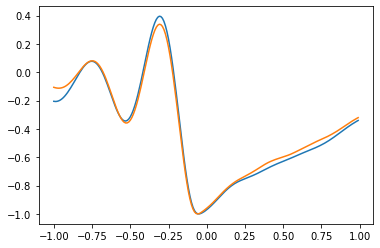

In [17]:
# xcorr
corr_kernel=np.correlate(x_selected[len(equi_temp_k)-1:],y_equi_temp_k,'same')
corr1=corr_kernel[int(len(corr_kernel+1)/2)-int(1/dt):int(len(corr_kernel+1)/2)+int(1/dt)]
corr1=corr1/max(abs(corr1))

corr_NGD=np.correlate(x_selected[len(kx)-1:],y_NGD,'same')
corr2=corr_NGD[int(len(corr_NGD+1)/2)-int(1/dt):int(len(corr_NGD+1)/2)+int(1/dt)]
corr2=corr2/max(abs(corr2))

timelag=np.arange(-int(1/dt),int(1/dt))*dt
plt.plot(timelag,-corr1)
plt.plot(timelag,-corr2)
plt.xlim()